# Assignment 2

In this assignment, you will be working on an image classification task (codename `pnp`) using the transfer learning technique.
The task objective is to determine whether an image contains a person (`pnp` stands for person / non-person) -- a binary classification task.

## Dataset
* Dataset contains 80K images with known labels (for model development), and 20K images with unknown labels (for scoring).
* Dataset has been created from a subset of COCO Dataset, and so all copyrights belong to the original authors: https://cocodataset.org/#termsofuse
* Images have been rescaled and padded to be of shape (224, 224, 3).

While it's possible to create a new model architecture and train a model specifically for this task, that would be expensive in terms of time and cloud resources.
Instead, in this assignment, you will be re-using an pre-trained model's architecture and parameters to save time and cloud resources.

## MobileNet Architecture
* The pre-trained model's name is MobileNetV2: https://arxiv.org/pdf/1801.04381.pdf
* MobileNet is a relatively small network that is designed for usage on mobile devices with limited compute and storage resource.
* It's a great choice for this assignment, since this network can be relatively quickly processed with a single GPU.

## MobileNet Parameters
* Keras provides network architecture and pre-trained parameters: https://keras.io/api/applications/mobilenet/#mobilenetv2-function
* The pre-trained parameters come from the ImageNet 1000-class task, which does not include a person label.
* The lower part of the network can be reused due to the shared hierarchy of visual information..


In [1]:
!ls pnp_dataset || (wget https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip && unzip pnp_dataset.zip >/dev/null 2>&1)

score_x  train_x  train_y.npy


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def load_images(folder: str):
    imgs = []

    paths = !find {folder} -type f
    paths = sorted(paths)

    for path in paths:
        with open(path, 'r') as f:
            imgs.append(plt.imread(path))
            
    return np.array(imgs)

In [3]:
train_x = load_images('pnp_dataset/train_x')
score_x = load_images('pnp_dataset/score_x')
train_y = np.load('pnp_dataset/train_y.npy')

In [4]:
train_x.shape, train_y.shape

((80000, 224, 224, 3), (80000,))

In [5]:
train_y[:5]

array([1, 0, 1, 1, 1])

1

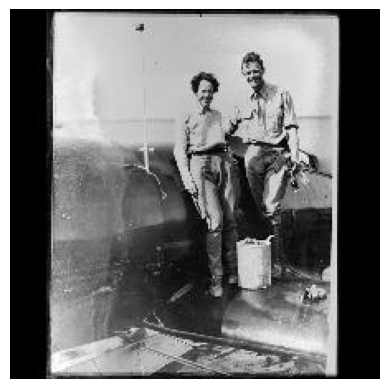

In [6]:
plt.imshow(train_x[0])
plt.axis('off')
train_y[0]

0

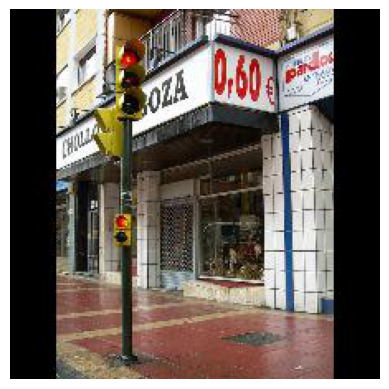

In [7]:
plt.imshow(train_x[1])
plt.axis('off')
train_y[1]

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.1, random_state=11)

In [10]:
# This configures the GPU to be used by Tensorflow.

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [12]:
# https://arxiv.org/pdf/1801.04381.pdf
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)

In [13]:
# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
mobile_net.trainable = False

In [14]:
# mobile_net.summary()

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip('horizontal', seed=11),
    tf.keras.layers.RandomRotation(0.2, seed=11),
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),
    mobile_net,
    #tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(1, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(units=1)
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                        

In [17]:
model.compile(
    #optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ]
)
batch_size = 128  #128

/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
with tf.device('/CPU:0'):
    x_train = tf.constant(x_train)
    y_train = tf.constant(y_train)
    x_val = tf.constant(x_val)
    y_val = tf.constant(y_val)
    score_x = tf.constant(score_x)

2022-10-09 02:46:12.234454: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 10838016000 exceeds 10% of free system memory.
2022-10-09 02:46:20.985928: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3010560000 exceeds 10% of free system memory.


In [19]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/10


2022-10-09 02:46:43.345444: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-10-09 02:46:44.338458: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


563/563 [==============================] - 198s 339ms/step - loss: 0.3815 - binary_accuracy: 0.8225 - val_loss: 0.3137 - val_binary_accuracy: 0.8616
Epoch 2/10
563/563 [==============================] - 190s 338ms/step - loss: 0.3363 - binary_accuracy: 0.8490 - val_loss: 0.3187 - val_binary_accuracy: 0.8621
Epoch 3/10
563/563 [==============================] - 190s 338ms/step - loss: 0.3219 - binary_accuracy: 0.8552 - val_loss: 0.3093 - val_binary_accuracy: 0.8670
Epoch 4/10
563/563 [==============================] - 191s 338ms/step - loss: 0.3075 - binary_accuracy: 0.8628 - val_loss: 0.2948 - val_binary_accuracy: 0.8706
Epoch 5/10
563/563 [==============================] - 191s 339ms/step - loss: 0.2992 - binary_accuracy: 0.8665 - val_loss: 0.2996 - val_binary_accuracy: 0.8712
Epoch 6/10
563/563 [==============================] - 191s 339ms/step - loss: 0.2902 - binary_accuracy: 0.8702 - val_loss: 0.3033 - val_binary_accuracy: 0.8684
Epoch 7/10
563/563 [==============================]

In [20]:
mobile_net.trainable = True

In [21]:
fine_tune_at = 100
for layer in mobile_net.layers[:fine_tune_at]:
    layer.trainable = False

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=0.0001/10),
    #optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ]
)

/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.10/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [23]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(x_train,
                         y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         batch_size=batch_size,
                         validation_data=(x_val, y_val))

Epoch 10/20
563/563 [==============================] - 274s 475ms/step - loss: 0.3152 - binary_accuracy: 0.8582 - val_loss: 0.2993 - val_binary_accuracy: 0.8706
Epoch 11/20
563/563 [==============================] - 267s 473ms/step - loss: 0.2854 - binary_accuracy: 0.8731 - val_loss: 0.2870 - val_binary_accuracy: 0.8813
Epoch 12/20
563/563 [==============================] - 268s 476ms/step - loss: 0.2695 - binary_accuracy: 0.8811 - val_loss: 0.2868 - val_binary_accuracy: 0.8805
Epoch 13/20
563/563 [==============================] - 270s 480ms/step - loss: 0.2585 - binary_accuracy: 0.8862 - val_loss: 0.2846 - val_binary_accuracy: 0.8810
Epoch 14/20
563/563 [==============================] - 268s 475ms/step - loss: 0.2473 - binary_accuracy: 0.8910 - val_loss: 0.2883 - val_binary_accuracy: 0.8820
Epoch 15/20
563/563 [==============================] - 267s 475ms/step - loss: 0.2403 - binary_accuracy: 0.8951 - val_loss: 0.2881 - val_binary_accuracy: 0.8823
Epoch 16/20
563/563 [=============

In [24]:
import os 
import pandas as pd

model_dir = 'pnp_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the model on the score dataset.
score_y_hat = pd.DataFrame(
    model.predict(score_x, batch_size=batch_size),
    # This is needed to save the file in Parquet format.
    columns=['score']
)

# Now save it to disc as a Parquet file.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), indent=True))

# Finally, let's save the learned parameters.
model.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.json -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset

In [25]:
score_y_hat

score
0      0.592801
1      0.278196
2      0.146294
3      0.991990
4      0.131818
...         ...
19995  0.041262
19996  0.027987
19997  0.999488
19998  0.000553
19999  0.998159

[20000 rows x 1 columns]